## Langchain: Let's Start With The Basics

This is a Python notebook. It allows us to run code segments and see the results. There's a series of imports that we'll do first and then load the models from OpenAI

[LangChain Providers](https://python.langchain.com/docs/integrations/providers)

NOTE: You will need to have an environment variable of OPENAI_API_KEY with your key value

In [2]:
pip install -q openai langchain langchain_experimental


[notice] A new release of pip is available: 25.0 -> 25.1.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


# Sequential Chain

This is an example of a sequential pipeline (or "chain") of prompts:

Each step is predefined and runs in order.
There is no dynamic decision-making or tool selection.
The flow is fixed: extract features → assess risks → suggest mitigations.

In [1]:
# Simulated Multi-Step Reasoning with LangChain
# Scenario: Medical Device R&D - Usability and Risk Assessment Pipeline

from langchain_openai import ChatOpenAI
from langchain_core.prompts import PromptTemplate
from langchain_core.runnables import RunnableSequence
import os

# Initialize OpenAI LLM using environment variable for the API key
llm = ChatOpenAI(model_name="gpt-4", temperature=0.3)

# Step 1: Extract Features
product_description = "The catheter is designed with a dual-lumen shaft, embedded pressure sensor, and balloon inflation system optimized for cardiovascular access."

step1_prompt = PromptTemplate(
    input_variables=["description"],
    template="""
Extract 3-5 key features of the medical device described below.
Product Description:
{description}
"""
)
step1_chain = step1_prompt | llm
features = step1_chain.invoke({"description": product_description})

# Step 2: Risk Assessment
step2_prompt = PromptTemplate(
    input_variables=["features"],
    template="""
For each of the following features, identify a potential usability or safety risk and briefly explain the concern.
Features:
{features}
"""
)
step2_chain = step2_prompt | llm
risks = step2_chain.invoke({"features": features})

# Step 3: Mitigation
step3_prompt = PromptTemplate(
    input_variables=["risks"],
    template="""
Based on the following risks, recommend one mitigation strategy per risk.
Risks:
{risks}
"""
)
step3_chain = step3_prompt | llm
mitigations = step3_chain.invoke({"risks": risks})

# Output all
print("Features:\n", features)
print("\nRisks:\n", risks)
print("\nMitigations:\n", mitigations)


Features:
 content='1. Dual-lumen shaft: The catheter is designed with a dual-lumen shaft, which allows for multiple uses or functions through the same device, such as simultaneous fluid delivery and pressure monitoring.\n\n2. Embedded pressure sensor: The device includes an embedded pressure sensor, which allows for real-time monitoring of the pressure within the cardiovascular system. This can provide critical information during medical procedures.\n\n3. Balloon inflation system: The catheter is equipped with a balloon inflation system, which is optimized for cardiovascular access. This feature can be used to temporarily block a vessel or to widen a narrow or blocked artery.' additional_kwargs={'refusal': None} response_metadata={'token_usage': {'completion_tokens': 121, 'prompt_tokens': 50, 'total_tokens': 171, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_to

# Other Chains!

As we talked already about simple sequential chains and their power, let's talk about other specific chains!

# SQLDatabase Chain

One of the cool things is that you can build chains for specific purposes. Let's explore what a SQLDatabaseChain might look like.

I have a simple SQLlite database loaded with information on artists, albums and other information sold

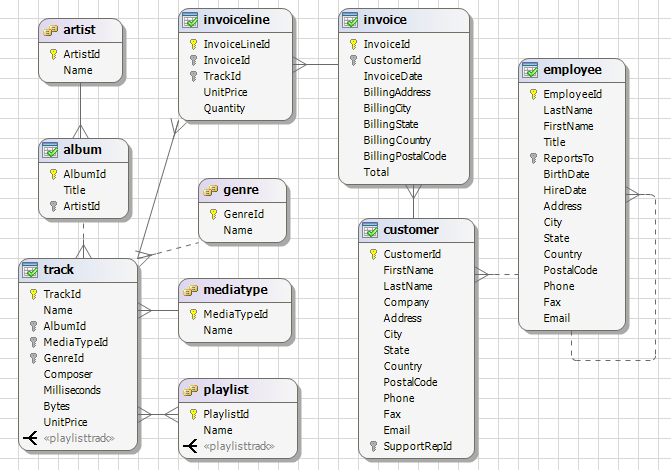

In [3]:
from langchain_community.utilities import SQLDatabase
from langchain_experimental.sql import SQLDatabaseChain
from langchain_openai import OpenAI

db = SQLDatabase.from_uri("sqlite:///Chinook.db")
llm = OpenAI(temperature=0, verbose=True)
db_chain = SQLDatabaseChain.from_llm(llm, db, verbose=True)

In [4]:
# start simple.. just ask a question
#db_chain.run("How many employees are there?")

# let's get a list of all the sales
#db_chain.run("List the total sales per country and list the top 5") # NOTE: Smart enough to look at Invoice table!

# let's get a list of all the sales, but then ask it to tell us which country's customers spent the most
#db_chain.run("List the total sales per country. Which country's customers spent the most")

# let's get a description of the playlisttrack table in plain english. Super powerful!
db_chain.run("Describe the playlisttrack table")

/var/folders/fn/f1_5kmtj0wd5w15pp0qnlf780000gn/T/ipykernel_86706/122135934.py:11: LangChainDeprecationWarning: The method `Chain.run` was deprecated in langchain 0.1.0 and will be removed in 1.0. Use :meth:`~invoke` instead.
  db_chain.run("Describe the playlisttrack table")




> Entering new SQLDatabaseChain chain...
Describe the playlisttrack table
SQLQuery:SELECT * FROM PlaylistTrack LIMIT 5
SQLResult: [(1, 3402), (1, 3389), (1, 3390), (1, 3391), (1, 3392)]
Answer:The playlisttrack table contains the relationship between playlists and tracks. Each row represents a track that is included in a specific playlist. The table has two columns: PlaylistId and TrackId, both of which are foreign keys referencing the Playlist and Track tables, respectively.
> Finished chain.


'The playlisttrack table contains the relationship between playlists and tracks. Each row represents a track that is included in a specific playlist. The table has two columns: PlaylistId and TrackId, both of which are foreign keys referencing the Playlist and Track tables, respectively.'

## PAL Math Chain
PAL stands for Program-Aided Language Models. It allows us to use a smart chain that will write code to solve a problem!
This allows for the results to be deterministic and not at the whim of the model to make things up or give false output

In [5]:
from langchain.llms import OpenAI
from langchain_experimental.pal_chain.base import PALChain

In [6]:
llm = OpenAI()

/var/folders/fn/f1_5kmtj0wd5w15pp0qnlf780000gn/T/ipykernel_86706/1506918662.py:1: LangChainDeprecationWarning: The class `OpenAI` was deprecated in LangChain 0.0.10 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-openai package and should be used instead. To use it run `pip install -U :class:`~langchain-openai` and import as `from :class:`~langchain_openai import OpenAI``.
  llm = OpenAI()


In [8]:
pal_chain = PALChain.from_math_prompt(llm, verbose=True, allow_dangerous_code=True)

## Testing out Math Prompts
Let's try out a few options.

Look at the questions below and try each of them to see what happens as you run them through the chain

In [9]:
question_01 = "Jan has three times the number of pets as Marcia. Marcia has two more pets than Cindy. If Cindy has four pets, how many total pets do the three have?"
question_02 = "The cafeteria had 23 apples. If they used 20 for lunch and bought 6 more, how many apples do they have?"

In [10]:
pal_chain.run(question_02)



> Entering new PALChain chain...


Python REPL can execute arbitrary code. Use with caution.


def solution():
    """The cafeteria had 23 apples. If they used 20 for lunch and bought 6 more, how many apples do they have?"""
    apples_initial = 23
    apples_used = 20
    apples_bought = 6
    total_apples = apples_initial - apples_used + apples_bought
    result = total_apples
    return result

> Finished chain.


'9'

## API Chains - OpenMeteo - Weather information

In [11]:
from langchain import OpenAI
from langchain.chains.api.prompt import API_RESPONSE_PROMPT

from langchain.chains import APIChain
from langchain.prompts.prompt import PromptTemplate


In [12]:
llm = OpenAI(temperature=0,
             max_tokens=100)

from langchain.chains.api import open_meteo_docs
chain_new = APIChain.from_llm_and_api_docs(llm,
                                           open_meteo_docs.OPEN_METEO_DOCS,
                                           limit_to_domains=None,
                                           verbose=True)

In [13]:
chain_new.run('What is the temperature like right now in Minneapolis in degrees Fahrenheit?')



> Entering new APIChain chain...
 https://api.open-meteo.com/v1/forecast?latitude=44.9778&longitude=-93.2650&hourly=temperature_2m&current_weather=true&temperature_unit=fahrenheit&timezone=auto
{"latitude":44.96949,"longitude":-93.26296,"generationtime_ms":0.08869171142578125,"utc_offset_seconds":-18000,"timezone":"America/Chicago","timezone_abbreviation":"GMT-5","elevation":253.0,"current_weather_units":{"time":"iso8601","interval":"seconds","temperature":"°F","windspeed":"km/h","winddirection":"°","is_day":"","weathercode":"wmo code"},"current_weather":{"time":"2025-06-05T15:00","interval":900,"temperature":79.9,"windspeed":14.5,"winddirection":215,"is_day":1,"weathercode":0},"hourly_units":{"time":"iso8601","temperature_2m":"°F"},"hourly":{"time":["2025-06-05T00:00","2025-06-05T01:00","2025-06-05T02:00","2025-06-05T03:00","2025-06-05T04:00","2025-06-05T05:00","2025-06-05T06:00","2025-06-05T07:00","2025-06-05T08:00","2025-06-05T09:00","2025-06-05T10:00","2025-06-05T11:00","2025-06-

' The current temperature in Minneapolis is 79.9 degrees Fahrenheit. This information was obtained from the API url: https://api.open-meteo.com/v1/forecast?latitude=44.9778&longitude=-93.2650&hourly=temperature_2m&current_weather=true&temperature_unit=fahrenheit&timezone=auto.'